# Quant basics

Bem vindo ao projetinho do Turing Quant!

Neste notebook você aprenderá os seguinte assuntos:

- Importação e visualização de dados financeiros
- Retornos e Risco de um ativo
- Análise de portfólios
- Previsão de Series Temporais

## 1. Importação de dataset de preço histórico

Para a importação de dados existem diversas bibliotecas em python que fornem preços históricos de ativos

Dentre elas podemos citar as seguinte plataformas:

- Google Finance (Via panda_datareader)
- Yahoo Finace (Via panda_datareader ou yfinance)
- Quandl
- Investing.com (investpy)

Pesquise sobre como importar dados nessas bibliotecas. Os datasets que conseguimos com essas bibliotecas são denominados OHLCV (open-high-low-close-volume).

- 1.1) Plote os preços de fechamento
- 1.2) Faça uma simples análise qualitativa do ativo escolhido (Ex: porque ele teve grande variação em algum momento)

In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [2]:
apple_data = data.DataReader('AAPL', 'yahoo', start='2013-01-01', end='2021-01-01')
apple_data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.352829
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.050766
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.239273
2020-12-30,135.990005,133.399994,135.580002,133.720001,96452100.0,133.094650
2020-12-31,134.740005,131.720001,134.080002,132.690002,99116600.0,132.069473


Text(0.5, 1.0, 'Análise das ações da Apple')

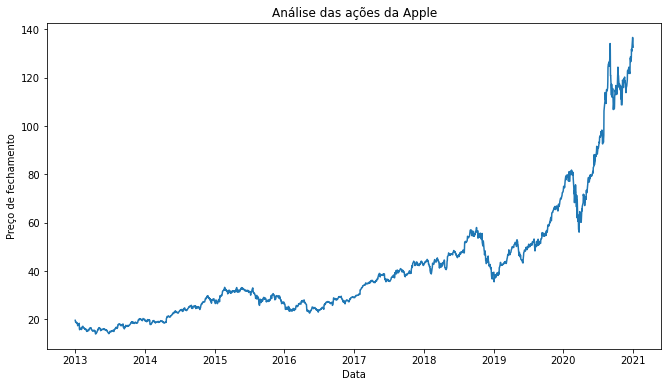

In [3]:
fig, ax = plt.subplots(figsize = (11, 6))
ax.plot(apple_data.index, apple_data["Close"])
ax.set_xlabel("Data")
ax.set_ylabel("Preço de fechamento")
ax.set_title("Análise das ações da Apple")

## Análise qualitativa

De maneira geral, podemos notar que o ativo apresentou uma tendência à valorização, ele apresentou uma acentuada queda no começo de 2020, a principal razão para isso foi a pandemia de covid-19.

# 2. Retorno e Risco

Essencialmente, a natureza do Mercado Financeiro é baseada em um certo nível de retorno (a variação do seu investimento) para um dado nível de risco (o quão provável é esse retorno). Há uma série de maneiras para mensurar o risco, mas geralmente elas estão ligadas à volatilidade do ativo, que, em sua forma mais simples, é o desvio padrão dos preços em um dado período.

Com o mesmo ativo que você importou anteriormente, iremos iniciar os calculos de risco e retorno. Porém inicialmente iremos analisar retorno e risco com o preço de fechamento.

## Retorno

Existem algumas maneiras de se calcular o retorno de uma série temporal, aqui podemos citar duas:

- 2.1) Retorno Percentual: $R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$
- 2.2) Retorno Logaritmo: $r_t = \ln(\frac{P_t}{P{t-1}}) = \ln(P_t) - \ln(P_{t-1})$

Sendo $P_t$ o preço no tempo t, e $P_{t-1}$ preço no tempo $t-1$ (Dia anterior).

Manipulando o dataframe implemente esse dois tipos de retonos e compare-os. 

Calcule os retornos cumulativos ao longo do tempo:

- 2.3) Retorno Cumulativo Percentual: 

$R_{cum} = \prod_{t=0}^{t = \text{max dias}}{(1 + R_{t})} =  (1+R_{t-\text{max dias}}) * \dots * (1+R_{t-1}) * (1+R_t)$
- 2.4) Retorno Cumulativo Logaritmo: 

$r_{cum} = \sum_{t = 0}^{t = \text{max dias}}{(1 + r_t)} = (1+r_{t-\text{max dias}}) + \dots + (1+r_{t-1}) + (1+r_t)$

In [4]:
def retorno_percentual(df):
    rp = df/df.shift(1) - 1
    return rp

def retorno_logaritmo(df):
    rl = np.log(df) - np.log(df.shift(1))
    return rl

def retorno_cumulativo_percentual(rp):
    return (1+rp).prod()

def retorno_cumulativo_logaritmo(rl):
    return rl.sum()

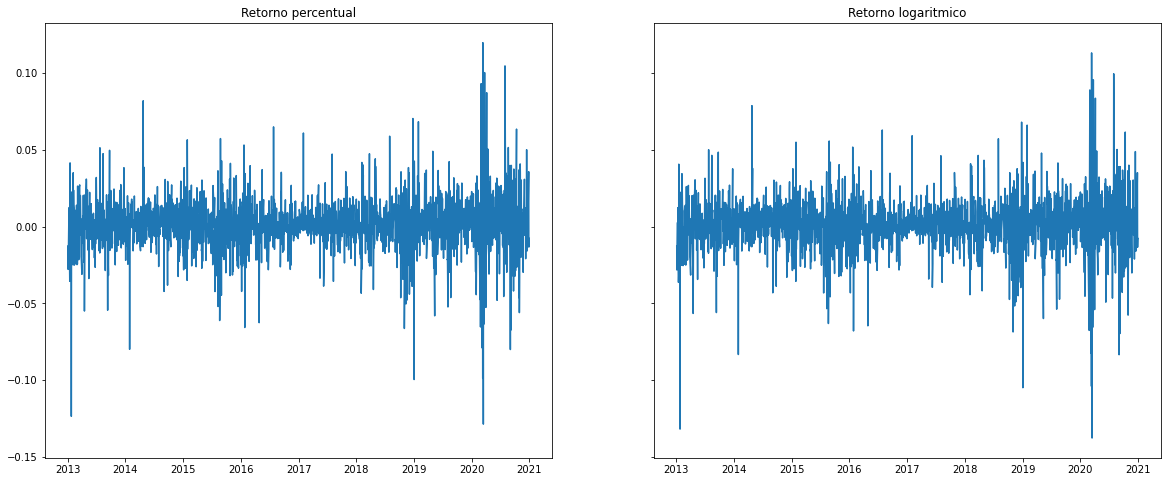

In [5]:
retp = retorno_percentual(apple_data["Close"])
retl = retorno_logaritmo(apple_data["Close"])

fig, ax = plt.subplots(1, 2, sharey = True, figsize = (20, 8))
ax[0].plot(apple_data.index, retp)
ax[0].set_title("Retorno percentual")
ax[1].plot(apple_data.index, retl)
ax[1].set_title("Retorno logaritmico")
plt.show()

Podemos notar que o retorno logaritmico apresenta valores em módulo menores do que o retorno percentual em situações de valorização do ativo, enquanto que na desvalorização ocorre o contrário.

In [6]:
retcump = retorno_cumulativo_percentual(retp)
retcuml = retorno_cumulativo_logaritmo(retl)
print("O retorno cumulativo percentual é de " + str(retcump))
print("O retorno cumulativo logaritmico é de " + str(retcuml))

O retorno cumulativo percentual é de 6.767062330848447
O retorno cumulativo logaritmico é de 1.9120670682093568


## Risco

Há diversos tipo de definições de risco, em finança quantitativas uma maneira bem fácil de calcular o risco é a partir da variação do ativo. Basicamente, você não quer investir num ativo que varia muito, ou seja, muito imprevisível. Uma maneira estátistica de cálcular essa volatilidade é a partir do desvio padrão.

- 2.5) Calcule o desvio padrão do ativo

Apenas o valor do desvio padrão não apresenta muita informação, então iremos calcular o rolling std. Básicamente iremos calcular o desvio padrão a cada t intervalo de tempo.

- 2.6) Calcule o rolling std

Dica: utilize o método ```pandas.rolling(window).std()``` do pandas, window é o intervalo em que você irá calcular o desvio padrão

- 2.7) Calcule o desvio padrão exponencial móvel (EWMA)

## Desafio

- 2.8) Calcule o desvio padrão estimado pelo High e Low ([Parkinson Number](https://www.ivolatility.com/help/3.html))
<img src="https://miro.medium.com/proxy/0*t4hSod9UQhA3Lsmz.png">

- 2.9) Calcule o desvio padrão estimado por High, Low, Close e Open ([Garman-Klass](https://portfolioslab.com/garman-klass))

<img src="https://miro.medium.com/max/1400/0*S6HDttTDL2p0GCC2.png">

Temos uma breve explicação desses estimadores de volatilidade em nosso Turing Talks: [Construindo uma Estratégia de Investimentos Quantitativa — Time Series Momentum](https://medium.com/turing-talks/construindo-uma-estrat%C3%A9gia-de-investimentos-quantitativa-time-series-momentum-7e60a40636bd)

In [7]:
def desvio_padrao(df):
    return df["Close"].std()

def rolling_std(df, tempo):
    return df.rolling(tempo).std()

def EWMA_vol (returns, com = 60):   
    ewm_window = returns.ewm(com=com)
    return ewm_window.std()

def parkinson_number(df, n):
    parcela = (np.log(df["High"]/df["Low"]))**2
    parkinson = parcela.rolling(n).sum()
    parkinson = np.sqrt(parkinson*1/(4*n*np.log(2)))
    return parkinson

def garman_klass_number(df, n):
    parcela = 0.5*(np.log(df["High"]/df["Low"]))**2 -(2*np.log(2)-1)*(np.log(df["Close"]/df["Open"]))**2
    garman_klass = parcela.rolling(n).sum()
    garman_klass = np.sqrt(garman_klass*(1/n))
    return garman_klass


In [8]:
desvio_padrao(apple_data)

24.995352194561885

In [9]:
rolling_std(apple_data, 12)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-12-24,3.858857,4.032155,3.957361,3.811557,4.137927e+07,3.793729
2020-12-28,4.566632,4.429431,4.413027,4.365872,4.154164e+07,4.345451
2020-12-29,4.983704,4.531758,4.796604,4.458427,4.041554e+07,4.437574


In [10]:
EWMA_vol(retorno_percentual(apple_data["Close"]))

Date
2013-01-02         NaN
2013-01-03         NaN
2013-01-04    0.010771
2013-01-07    0.011287
2013-01-08    0.012944
                ...   
2020-12-24    0.023881
2020-12-28    0.024046
2020-12-29    0.023947
2020-12-30    0.023799
2020-12-31    0.023644
Name: Close, Length: 2015, dtype: float64

In [11]:
parkinson_number(apple_data, 30)

Date
2013-01-02         NaN
2013-01-03         NaN
2013-01-04         NaN
2013-01-07         NaN
2013-01-08         NaN
                ...   
2020-12-24    0.013743
2020-12-28    0.013974
2020-12-29    0.014327
2020-12-30    0.014246
2020-12-31    0.014376
Length: 2015, dtype: float64

In [12]:
garman_klass_number(apple_data, 30)

Date
2013-01-02         NaN
2013-01-03         NaN
2013-01-04         NaN
2013-01-07         NaN
2013-01-08         NaN
                ...   
2020-12-24    0.014043
2020-12-28    0.014180
2020-12-29    0.014422
2020-12-30    0.014283
2020-12-31    0.014415
Length: 2015, dtype: float64

# 3. Lidando com portfolios
 
[Notebook de auxilio](https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Introduction_to_NumPy/notebook.ipynb)

Agora que você já aprendeu como importar preços históricos e como calcular o risco e retorno de ativos, podemos usar esse conhecimento para começar a montar o nosso portfolio!

Nessa etapa, você irá montar uma carteira com 4 ações diferentes. 
 - Use o que você aprendeu nas etapas anteriores para construir um dataframe com 4 ativos diferentes junto com os seus respectivos **dados históricos de fechamento**.
 
Em seguida, você precisa distribuir a porcentagem que cada ativo da sua carteira receberá dos seus investimentos. Em finanças, chamamos isso de [pesos de um portfolio](https://www.investopedia.com/terms/p/portfolio-weight.asp)
 - Atribua pesos ($w$) para cada um dos ativos que estão na sua carteira (Ele devem somar 1) . Ex: w = [0.3, 0.3, 0.2, 0.2]

## Retorno

Agora, você pode calcular o **retorno** do seu portfolio. 

O retorno para um período é dado pela seguinte fórmula: $R = \vec{r} \times \vec{w}$

Onde $\vec{r}$ é o vetor de retornos de cada ativo da carteira, e $\vec{w}$ os seus respectivos pesos.

- 3.1) Calcule o **retorno** para cada dia da série temporal

- 3.2) Faça um gráfico para visualizar os **retornos cumulativos** do seu portfolio e compare com algum benchmark (EX: IBOV). 

In [13]:
acoes = data.DataReader(['AAPL34.SA', 'PETR4.SA', 'BBAS3.SA', 'MGLU3.SA'], 'yahoo', start='2016-01-01', end='2021-01-01')
acoes.tail()

Attributes  Adj Close                                       Close             \
Symbols     AAPL34.SA   PETR4.SA   BBAS3.SA   MGLU3.SA  AAPL34.SA   PETR4.SA   
Date                                                                           
2020-12-22  68.655304  24.908234  36.453197  25.115610  68.980003  27.280001   
2020-12-23  67.580383  25.519983  37.052975  24.925945  67.900002  27.950001   
2020-12-28  71.362488  25.729984  37.462345  25.205452  71.699997  28.180000   
2020-12-29  69.670494  25.812160  37.243382  25.235399  70.000000  28.270000   
2020-12-30  68.675201  25.876074  36.938736  24.931921  69.000000  28.340000   

Attributes                             High             ...        Low  \
Symbols      BBAS3.SA   MGLU3.SA  AAPL34.SA   PETR4.SA  ...   BBAS3.SA   
Date                                                    ...              
2020-12-22  38.290001  25.160000  69.360001  27.469999  ...  38.000000   
2020-12-23  38.919998  24.969999  69.300003  28.250000  ...  38.270000   
2020-12-28  39.349998  25.250000  72.440002  28.520000  ...  39.200001   
2020-12-29  39.119999  25.280001  72.449997  28.430000  ...  38.950001   
2020-12-30  38.799999  24.950001  71.099998  28.490000  ...  38.660000   

Attributes                  Open                                      Volume  \
Symbols      MGLU3.SA  AAPL34.SA   PETR4.SA   BBAS3.SA   MGLU3.SA  AAPL34.SA   
Date                                                                           
2020-12-22  24.850000  66.699997  27.200001  38.139999  25.290001   402530.0   
2020-12-23  24.969999  69.300003  27.430000  38.570000  25.250000   185962.0   
2020-12-28  24.400000  69.000000  28.360001  39.320000  24.780001   369917.0   
2020-12-29  25.020000  72.209999  28.379999  39.500000  25.230000   203848.0   
2020-12-30  24.950001  71.000000  28.350000  39.279999  25.370001  1462286.0   

Attributes                                      
Symbols       PETR4.SA    BBAS3.SA    MGLU3.SA  
Date                                            
2020-12-22  46513200.0  10770400.0  25236200.0  
2020-12-23  49038900.0   9176300.0  20558600.0  
2020-12-28  36313300.0   7577200.0  23099100.0  
2020-12-29  29891100.0   7301400.0  17789700.0  
2020-12-30  36968200.0   8594000.0  19188700.0  

[5 rows x 24 columns]

In [14]:
w = [0.4, 0.2, 0.3, 0.1]
retp = retorno_percentual(acoes["Close"])
retorno_portfolio = retp.dot(w)
retorno_portfolio

Date
2016-01-04         NaN
2016-01-05   -0.003475
2016-01-06   -0.025979
2016-01-07   -0.043175
2016-01-08    0.005121
                ...   
2020-12-22    0.029335
2020-12-23    0.002830
2020-12-28    0.028467
2020-12-29   -0.010480
2020-12-30   -0.008978
Length: 1242, dtype: float64

In [15]:
def retorno_cumulativo(df):
    return (1+df).cumprod()

In [16]:
retorno_cumulativo_portfolio = retorno_cumulativo(retorno_portfolio)
retorno_cumulativo_portfolio

Date
2016-01-04         NaN
2016-01-05    0.996525
2016-01-06    0.970636
2016-01-07    0.928730
2016-01-08    0.933485
                ...   
2020-12-22    9.031304
2020-12-23    9.056864
2020-12-28    9.314690
2020-12-29    9.217073
2020-12-30    9.134318
Length: 1242, dtype: float64

In [17]:
benchmark = data.DataReader('^BVSP', 'yahoo', start='2016-01-01', end='2021-01-01')
benchmark.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-22,116903.0,115648.0,115825.0,116348.0,6947900.0,116348.0
2020-12-23,118311.0,116636.0,116636.0,117857.0,6483300.0,117857.0
2020-12-28,119213.0,117805.0,117806.0,119051.0,7171700.0,119051.0
2020-12-29,119861.0,118750.0,119130.0,119475.0,6769700.0,119475.0
2020-12-30,120150.0,118919.0,119410.0,119306.0,8235700.0,119306.0


In [18]:
retb = retorno_percentual(benchmark["Close"])
retorno_cumulativo_benchmark = retorno_cumulativo(retb)
retorno_cumulativo_benchmark

Date
2016-01-04         NaN
2016-01-05    1.006597
2016-01-06    0.991267
2016-01-07    0.965687
2016-01-08    0.963717
                ...   
2020-12-22    2.760922
2020-12-23    2.796730
2020-12-28    2.825063
2020-12-29    2.835125
2020-12-30    2.831115
Name: Close, Length: 1236, dtype: float64

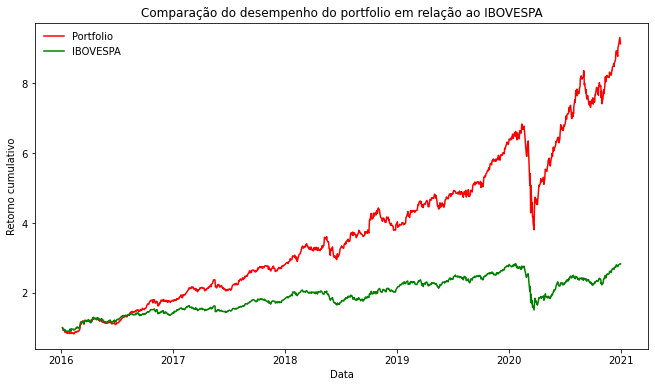

In [19]:
fig, ax = plt.subplots(figsize = (11, 6))
ax.plot(retorno_cumulativo_portfolio.index, retorno_cumulativo_portfolio, color = "r", label = "Portfolio")
ax.plot(retorno_cumulativo_benchmark.index, retorno_cumulativo_benchmark, color = "g", label = "IBOVESPA")
ax.set_xlabel("Data")
ax.set_ylabel("Retorno cumulativo")
ax.set_title("Comparação do desempenho do portfolio em relação ao IBOVESPA")
ax.legend(loc = "upper left", frameon = False)
plt.show()

## Risco

Para calcular um **risco** de um portfolio precisamos levar em conta as correlações entre todos os ativos. Para isso calcularemos a matriz de covariaças $C$ (```pandas.cov()``` ou ```np.cov()```).

A equação do risco de uma portfólio é dada pela seguinte fórmula: $\sigma = \sqrt{\vec{w}C\vec{w}^\mathsf{T}}$, sendo $T$ a tranposição de um array 

- 3.3) Calcule o risco de 3 portfólios (varie o vetor de pesos).

In [20]:
def risco_portfolio(df, w):
    covariancia = df.cov()
    risco = np.sqrt(w @ covariancia @ w.T)
    return risco

In [21]:
w1 = np.array([0.25, 0.25, 0.25, 0.25])
w2 = np.array([0.3, 0.3, 0.2, 0.2])
w3 = np.array([0.4, 0.2, 0.3, 0.1])

print("Risco com o portfolio 1" + str(risco_portfolio(acoes["Close"], w1)))
print("Risco com o portfolio 2" + str(risco_portfolio(acoes["Close"], w2)))
print("Risco com o portfolio 3" + str(risco_portfolio(acoes["Close"], w3)))

Risco com o portfolio 18.10755795060437
Risco com o portfolio 28.406085648311626
Risco com o portfolio 39.28075014099838


## Teoria Moderna de Portifolio - Markowitz 

Markowitz também conhecido como efficient frontier, é uma maneira de otimizar uma carteira de investimentos. A maneira mais simples de encontrar a melhor solução é via simulação. Portanto simula-se diversos pesos, e para cada peso é calculado seu retorno esperado e risco. 

- 3.4) Otimize a carteira e obtenha o portfolio com o melhor retorno ajustado ao risco (Sharpe Ratio)

<img src="https://miro.medium.com/max/864/1*RQrjkJQhgVLnpyo1lXbizA.png">

In [22]:
def generate_random_weights(num):
    weights = []
    for i in range(num):
        weight = np.random.random(4)
        weight_sum_to_1 = weight/(weight.sum())
        weights.append(weight_sum_to_1)
    return weights
    
def calcula_retorno_portfolio(retorno, weight):
    ret = retorno.dot(weight)
    return ret

def calcula_volatilidade_portfolio(covariancia, weight):
    vol = np.sqrt(weight @ covariancia @ weight.T)
    return vol

def calcula_sharpe_ratio(ret, vol, rfr):
    #converter risk free rate anual para diaria
    rfrd = (1+rfr)**(1/252) -1
    sr = (ret-rfrd)/vol
    return sr
    
def calcula_todos_portfolios(retorno_esperado, covariancia, risk_free_rate, num_portfolios):
    weights = generate_random_weights(num_portfolios)
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        ret = calcula_retorno_portfolio(retorno_esperado, weights[i])
        vol = calcula_volatilidade_portfolio(covariancia, weights[i])
        sharpe_ratio = calcula_sharpe_ratio(ret, vol, risk_free_rate)
        results[0][i] = ret
        results[1][i] = vol
        results[2][i] = sharpe_ratio
    return results, weights

def msr(retorno_esperado, covariancia, num_portfolios, risk_free_rate = 0.0178, show_graph = False):
    results, weights = calcula_todos_portfolios(retorno_esperado, covariancia, risk_free_rate, num_portfolios) 
    msr_idx = np.argmax(results[2])
    if show_graph:
        fig, ax = plt.subplots(figsize = (11, 6))
        im = ax.scatter(results[1,:], results[0, :], c = results[2, :], cmap ='spring', s= 20)
        cax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax = cax)
        ax.set_title("Resultados para portfolios gerados aleatoriamente")
        ax.set_ylabel("Retorno diario")
        ax.set_xlabel("Volatilidade diaria")
        
    return results[:, msr_idx], weights[msr_idx]

[0.004 0.03  0.122]
[0.704 0.001 0.007 0.287]


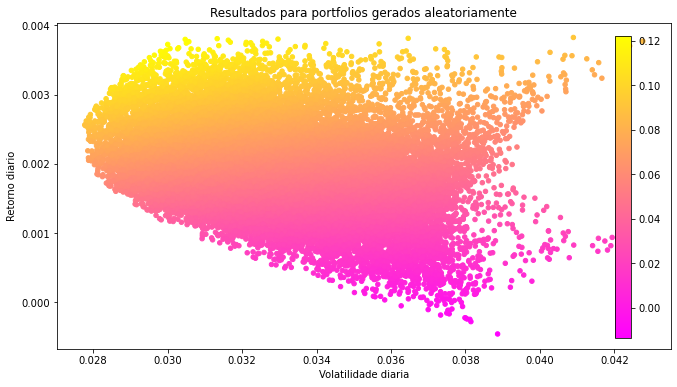

In [23]:
rets = retorno_percentual(acoes["01-01-2020":"01-01-2021"]["Close"])
a, b = msr(rets.mean(), rets.cov(), 25000, show_graph = True)
np.set_printoptions(precision = 3)
print(a)
print(b)

## Backtesting

Estratégia de investimento: Rebalanceamento mensal de uma carteira de investimentos.

- 3.5.1) Maneira simplificada: Calcular retornos mensais ao longo do tempo. Obtenha os pesos otimizado para o mês e calcule o rendimento do proxímo mês.
- 3.5.2) Maneira completa: Realize o rebalanceamento mensal e calcule os retornos diários. Fique atento que ao longo do mês os pesos do ativos variam.
- 3.6) Faça uma análise quantitativa e qualitativa da performace do backtesting.

In [24]:
def simula_rebalanceamento_mensal(retornos, ini_date, end_date):

    distribuicao_montante_nas_acoes = np.zeros(acoes.columns.shape)
    ini_d = pd.Timestamp(ini_date)
    end_d = pd.Timestamp(end_date)
    montante_diario = [1.]
    pesos = []
    i = ini_d
    while i <= end_d:
        #para calcular os retornos e a matriz de covariancia
        #nos baseamos no mes passado
        i_minus_one_month = i+pd.DateOffset(months = -1)
        retornos_no_mes = retornos[i_minus_one_month:i]
        retornos_esperados_no_mes = retornos_no_mes.mean()
        covariancia_no_mes = retornos_no_mes.cov()
        
        #calcula melhor portfolio
        _, melhores_pesos_pro_mes = msr(retornos_esperados_no_mes, retornos_no_mes.cov(), 1000)
        pesos.append(melhores_pesos_pro_mes)
        montante_atual = montante_diario[-1]
        distribuicao_montante_nas_acoes = montante_atual*melhores_pesos_pro_mes
        
        #calcular o retorno para os proximos dias no mes
        i_plus_one_month = i+pd.DateOffset(months = 1)
        retornos_proximo_mes = retornos[i:i_plus_one_month]
        while i<i_plus_one_month:
            if i in retornos_proximo_mes.index:
                #calcula nova distribuicao dos pesos
                
                nova_distribuicao = (1+retornos_proximo_mes[i:i])*distribuicao_montante_nas_acoes
                #registra o novo valor do montante
                novo_montante = nova_distribuicao.sum(axis = 1).values[0]
                montante_diario.append(novo_montante)
                #ajeita a distribuicao para ficar igual ao msr
                distribuicao_montante_nas_acoes = novo_montante*melhores_pesos_pro_mes
            i = i+pd.DateOffset(days = 1)
        
    return retornos[ini_d:end_d].index, montante_diario[1:], pesos

In [25]:
dias, montante_diario, pesos = simula_rebalanceamento_mensal(retorno_percentual(acoes["Close"]), "2016-02-01", "2021-01-01") 

In [26]:
dt = np.dtype("float,float,float,float")
pesos = np.array(pesos)
pesos.mean(axis = 0)

array([0.346, 0.185, 0.177, 0.291])

In [27]:
desempenho_portfolio = pd.DataFrame(montante_diario, index = dias, columns = ["msr"])
desempenho_portfolio

,msr
Date,
2016-02-01,1.018200
2016-02-02,0.949437
2016-02-03,0.963519
2016-02-04,0.996863
2016-02-05,0.985188
...,...
2020-12-22,22.379977
2020-12-23,22.474105
2020-12-28,23.200065


In [28]:
retornos = (1+retorno_percentual(acoes["Close"]))["2016-02-01":"2021-01-01"].cumprod()
desempenho_portfolio["magazine_luiza"] = retornos["MGLU3.SA"]
desempenho_portfolio["apple"] = retornos["AAPL34.SA"]
desempenho_portfolio["banco_do_brasil"] = retornos["PETR4.SA"]
desempenho_portfolio["petrobras"] = retornos["BBAS3.SA"]
desempenho_portfolio["ew"] = 0.25*(desempenho_portfolio["magazine_luiza"] + desempenho_portfolio["petrobras"]+desempenho_portfolio["banco_do_brasil"] +desempenho_portfolio["apple"])

Text(0, 0.5, 'Razão entre o valor atual e o final')

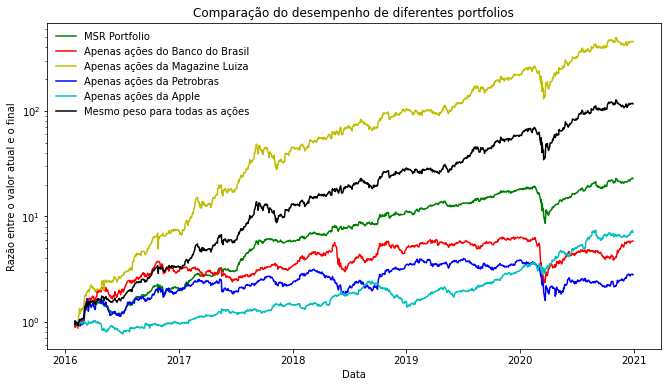

In [29]:
fig, ax = plt.subplots(figsize = (11, 6))
ax.plot(desempenho_portfolio.index, desempenho_portfolio["msr"], color = "g", label = "MSR Portfolio")
ax.plot(desempenho_portfolio.index, desempenho_portfolio["banco_do_brasil"], color = "r", label = "Apenas ações do Banco do Brasil")
ax.plot(desempenho_portfolio.index, desempenho_portfolio["magazine_luiza"], color = "y", label = "Apenas ações da Magazine Luiza")
ax.plot(desempenho_portfolio.index, desempenho_portfolio["petrobras"], color = "b", label = "Apenas ações da Petrobras")
ax.plot(desempenho_portfolio.index, desempenho_portfolio["apple"], color = "c", label = "Apenas ações da Apple")
ax.plot(desempenho_portfolio.index, desempenho_portfolio["ew"], color = "k", label = "Mesmo peso para todas as ações")
ax.set_yscale("log")
ax.legend(loc = "upper left", frameon = False)
ax.set_title("Comparação do desempenho de diferentes portfolios")
ax.set_xlabel("Data")
ax.set_ylabel("Razão entre o valor atual e o final")

No gráfico, utilizou-se a escala logarítmica para possibilitar a visualização de todas as ações. Podemos notar que as ações da Magazine Luiza tiveram um desempenho destoante das demais com valorização de mais de 40 000%, bem acima das demais. Além disso, o portfolio com pesos iniciais iguais, apresentou um desempenho superior ao portfolio que apresentava o maior sharpe ratio. Entre as razões para isso, podemos citar o desempenho acima da média das ações da Magazine Luiza, que alavancou o EW portfolio. Outra razão para um pior desempenho do MSR portfolio, foi o pouco preciso método utilizado para prever os retornos de cada mês, que tem um grande impacto na distribuição dos pesos.

# 4. Previsão de Time Series

## Cross validation em Séries Temporais

Sempre que lidamos com algoritmos de machine learning, para treiná-los temos que separar os datasets em treino e em teste. Em séries temporais não podemos separar os dados aleatoriamente, pois a ordem no tempo importa! Portanto, seguimos a seguinte separação ao longo do tempo:

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

## Feature Engineering em Série Temporal

Para inserir machine learning em séries temporais, precisamos efetuar o processo conhecido como feature engineering, que é básicamente construir as entradas de nosso modelo.

### Lags
Os dados mais simples que podemos inserir no nosso modelo são os valores passados.
Se deslocarmos (com a função `.shift(i)`) a série temporal em $i$ vezes, conseguimos estabelecer uma feature onde o valor atual no tempo $t$ é alinhado com um valor no tempo $t-i$. Chamamos isso de _lag_, ou atraso na série temporal. Isso é bastante útil, por exemplo, para estratégias baseadas em um valor histórico de uma feature.

### Demais features
Além dos pontos passados outras features podem ser inseridas no modelo: Volume de negociações, momentum, volatilidade, dados do mercado (ex: ibov) e etc.

- 4.1) Realize o feature engineering e teste alguns modelos de ML (Ex: Regressão linear, ARIMA, Decision Tree, Random Forest, Redes Neurais, etc...)
- 4.2) Faça um gráfico comparando os valores reais e preditos pelo modelo, durante um determinado período.
<br/>
Exemplo:
<br/>
<img width="500" height="500" src="https://miro.medium.com/max/1000/1*NvhZBDp5jNX-5Qd4LT7FEw.png">

In [30]:
training_set = acoes[:"30-06-2020"]["High"]["AAPL34.SA"].values
test_set = acoes["High"]["AAPL34.SA"].values

In [31]:
training_set = training_set.reshape((training_set.shape[0], 1))
test_set = test_set.reshape((test_set.shape[0], 1))

In [32]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.transform(test_set)

In [33]:
x_train = []
y_train = []

for i in range(60, training_set.shape[0]):
    x_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [34]:
x_test = []
y_test = []

for i in range(training_set.shape[0], test_set.shape[0]):
    x_test.append(test_set_scaled[i-60:i, 0])
    y_test.append(test_set_scaled[i, 0])
    
x_test = np.array(x_test)
y_test = np.array(y_test)

In [35]:
#Regressao linear
regr = LinearRegression()
regr.fit(x_train, y_train)

#Rede neural
nn= MLPRegressor()
nn.fit(x_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [36]:
y_pred_rl = regr.predict(x_test)
y_pred_rl = y_pred_rl.reshape((y_pred_rl.shape[0], 1))
y_pred_rl = sc.inverse_transform(y_pred_rl)
y_pred_nn = nn.predict(x_test)
y_pred_nn = y_pred_nn.reshape((y_pred_nn.shape[0], 1))
y_pred_nn = sc.inverse_transform(y_pred_nn)
y_test = y_test.reshape((y_test.shape[0], 1))
y_test = sc.inverse_transform(y_test)

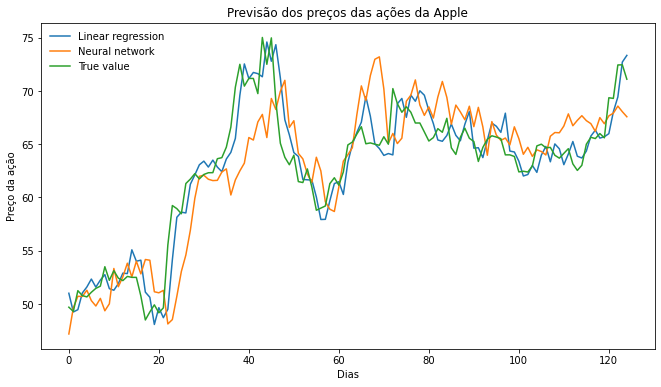

In [37]:
fig, ax = plt.subplots(figsize = (11, 6))
ax.plot(y_pred_rl, label = "Linear regression")
ax.plot(y_pred_nn, label = "Neural network")
ax.plot(y_test, label = "True value")
ax.set_title("Previsão dos preços das ações da Apple")
ax.set_ylabel("Preço da ação")
ax.set_xlabel("Dias")
ax.legend(frameon = False)
plt.show()

## LSTM

E por fim te desafiamos a implementar uma arquitetura de redes neurais para dados sequências: LSTM. Podem tomar como referência esse notebook, podem copiar o código, o intuito dessa etapa é que vocês tenham um contato com Deep Learning. (https://drive.google.com/file/d/1uagMXYRMJTdMJwoQbQD5LVfrYj4aUuSF/view?usp=sharing)

In [38]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [39]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(x_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
34/34 [==============================] - 6s 58ms/step - loss: 0.0145
Epoch 2/10
34/34 [==============================] - 2s 60ms/step - loss: 0.0054
Epoch 3/10
34/34 [==============================] - 2s 60ms/step - loss: 0.0043
Epoch 4/10
34/34 [==============================] - 2s 60ms/step - loss: 0.0036
Epoch 5/10
34/34 [==============================] - 2s 60ms/step - loss: 0.0045
Epoch 6/10
34/34 [==============================] - 2s 60ms/step - loss: 0.0030
Epoch 7/10
34/34 [==============================] - 2s 62ms/step - loss: 0.0033
Epoch 8/10
34/34 [==============================] - 2s 60ms/step - loss: 0.0026: 0s - loss
Epoch 9/10
34/34 [==============================] - 2s 60ms/step - loss: 0.0027
Epoch 10/10
34/34 [==============================] - 2s 60ms/step - loss: 0.0025


In [40]:
y_pred_lstm = regressor.predict(x_test)
y_pred_lstm = sc.inverse_transform(y_pred_lstm)

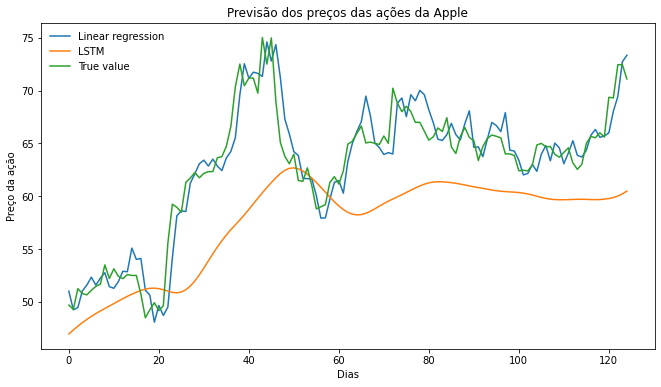

In [41]:
fig, ax = plt.subplots(figsize = (11, 6))
ax.plot(y_pred_rl, label = "Linear regression")
ax.plot(y_pred_lstm, label = "LSTM")
ax.plot(y_test, label = "True value")
ax.set_title("Previsão dos preços das ações da Apple")
ax.set_ylabel("Preço da ação")
ax.set_xlabel("Dias")
ax.legend(frameon = False)
plt.show()